# 6.5. Camadas personalizadas

Um fator por trás do sucesso do aprendizado profundo é a disponibilidade de uma ampla gama de camadas que podem ser compostas de maneiras criativas para projetar arquiteturas adequadas para uma ampla variedade de tarefas. 

Por exemplo, pesquisadores inventaram camadas especificamente para lidar com:
- imagens,
- texto,
- looping sobre dados sequenciais e
- execução de programação dinâmica. 

Mais cedo ou mais tarde, você precisará de uma camada que ainda não existe na estrutura de aprendizado profundo. Nesses casos, você deve construir uma camada personalizada. Nesta seção, mostramos como.

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 6.5.1. Camadas sem Parâmetros

Para começar, construímos uma camada personalizada que não tem nenhum parâmetro .

A classe CenteredLayer  a seguir simplesmente subtrai a média de sua entrada. 

Para construí-la, precisamos simplesmente herdar a classe da camada base e implementar a função de propagação para frente.

In [2]:
class CenteredLayer(nn.Module):    # herdar a classe da camada base (nn.Module).
    def __init__(self):            # camada sem argumentos de entrada.
        super().__init__()         # chama o método construtor (__init__()) da camada base (nn.Module).

    def forward(self, X):          # implementa a função de propagação para frente (forward).
        return X - X.mean()        # subtrai a média da entrada.

In [ ]:
class CenteredLayer(nn.Module):    # padrão.
    def __init__(self):            # padrão.
        super().__init__()         # padrão.
    
    def forward(self, X):          # padrão.
        return X - X.mean()        # Definições da classe. Ajustável conforme a necessidade.

Vamos verificar se nossa camada funciona conforme o esperado, alimentando alguns dados por meio dela.

In [3]:
# CenteredLayer(torch.tensor([1.0, 2, 3, 4, 5]))  # TypeError: CenteredLayer.__init__() takes 1 positional argument but 2 were given
# CenteredLayer só possui um argumento (sself), portanto, não pode receber argumentos.

layer = CenteredLayer()                  # cria-se o objeto layer, sem argumentos de entrada.
layer(torch.tensor([1.0, 2, 3, 4, 5]))   # agora layer pode receber argumentos, pois estes são do método construtor de nn.Module e não de CenteredLayer.
# class Module:    def __init__(self, *args, **kwargs) -> None:   ; portanto, pode receber argumentos.

tensor([-2., -1.,  0.,  1.,  2.])

Agora podemos incorporar nossa camada como um componente na construção de modelos mais complexos.

In [6]:
net = nn.Sequential(nn.LazyLinear(128), CenteredLayer())

C:\Users\zeh\pythonProject\.venv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
net

Sequential(
  (0): LazyLinear(in_features=0, out_features=128, bias=True)
  (1): CenteredLayer()
)

Como uma verificação extra, podemos enviar dados aleatórios pela rede e verificar se a média é de fato 0. 

Como estamos lidando com números de ponto flutuante, ainda podemos ver um número muito pequeno diferente de zero devido à quantização.

In [10]:
Y = net(torch.rand(4, 8))
Y.mean()

tensor(-1.8626e-09, grad_fn=<MeanBackward0>)

# 6.5.2. Camadas com Parâmetros

Agora que sabemos como definir camadas simples, vamos prosseguir para definir camadas com parâmetros que podem ser ajustados por meio de treinamento.

Podemos usar funções internas para criar parâmetros, que fornecem alguma funcionalidade básica de manutenção. 

Em particular, eles governam o acesso, a inicialização, o compartilhamento, o salvamento e o carregamento de parâmetros do modelo. 

Desta forma, entre outros benefícios, não precisaremos escrever rotinas de serialização personalizadas para cada camada personalizada.

Agora, vamos implementar nossa própria versão da camada totalmente conectada. Lembre-se de que essa camada requer dois parâmetros, um para representar o peso e o outro para o viés. 

Nessa implementação, utilizamos a ativação ReLU como padrão.

In [11]:
class MyLinear(nn.Module):
    def __init__(self, in_units, units): # argumentos de entrada: in_units e units, que denotam o número de entradas e saídas, respectivamente.
        super().__init__()               # chama o método construtor (__init__()) da camada base (nn.Module).
        self.weight = nn.Parameter(torch.randn(in_units, units))  # peso w
        self.bias = nn.Parameter(torch.randn(units,))             # bias b

    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data # linear = X*w + b
        return F.relu(linear)                                       # função de ativação ReLU. Normalmente é realizado na classe específica nn.ReLU(). 

Em seguida, instanciamos a classe MyLinear e acessamos seus parâmetros de modelo.

In [12]:
linear = MyLinear(5, 3)  # Agora, a classe deve receber parâmetros de entrada: in=5 e out=3.
linear.weight

Parameter containing:
tensor([[ 2.5597,  2.3036, -1.0389],
        [-0.8901,  1.1242, -0.7201],
        [ 2.0199, -1.3084,  0.6945],
        [ 1.3497,  0.8125,  0.5707],
        [-0.3388,  0.9355, -0.6992]], requires_grad=True)

Podemos realizar cálculos de propagação direta usando camadas personalizadas.

In [13]:
linear(torch.rand(2, 5))

tensor([[3.6352, 3.6293, 0.0000],
        [2.0814, 2.8069, 0.0000]])

Também podemos construir modelos usando camadas personalizadas. Uma vez que temos isso, podemos usá-lo como a camada totalmente conectada incorporada.

In [15]:
net = nn.Sequential(MyLinear(64, 8), 
                    MyLinear(8, 1))      # perceba que nn.ReLU() não foi utilizado, pois a mesma já se encontra incorporada na camada personalizada. 
                                                
net(torch.rand(2, 64))

# Utilizando as camadas padrões, a função de ativação encontra-se fora da camada Linear
# net = nn.Sequential(nn.Linear(64,8),
#                     nn.ReLU(),
#                     nn.Linear(8,1))          # Camada compatível seria:  nn.Linear(256,10) 
                    

tensor([[0.0000],
        [3.1005]])

# 6.5.4. Exercícios

# Ex. 1 - Projete uma camada que receba uma entrada e calcule uma redução de tensor, ou seja, ela retorna:

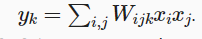

In [17]:
import torch
from torch import nn
from d2l import torch as d2l


class Tensor_reduction(nn.Module):
    def __init__(self, k, i, j): # argumentos de entrada: in_units e units, que denotam o número de entradas e saídas, respectivamente.
        super().__init__()       # chama o método construtor (__init__()) da camada base (nn.Module).
        self.w_kij = nn.Parameter(torch.randn(k,i,j))
        self.x_i = nn.Parameter(torch.randn(i))
        self.x_j = nn.Parameter(torch.randn(j))


    def forward(self, k_y):
        y = []
        for i in range(0, self.x_i.shape[0]):
            # print(f'i={i}')
            for j in range(0, self.x_j.shape[0]):
                # print(f'j={j}')
                y_k = self.w_kij[k_y][i][j] * self.x_i[i] * self.x_j[j]
                y.append(y_k)
        soma = sum(y)
        return soma       # função de ativação ReLU. Normalmente é realizado na classe específica nn.ReLU().

In [20]:
a = Tensor_reduction(2,2,3)

In [22]:
y = a.forward(0)
print(y)

tensor(0.8137, grad_fn=<AddBackward0>)


In [27]:
# Prova real de que a função está correta para k_y=0. Valor de y_0:
y1 = sum(
     [a.w_kij[0][0][0] * a.x_i[0] * a.x_j[0],
      a.w_kij[0][0][1] * a.x_i[0] * a.x_j[1],
      a.w_kij[0][0][2] * a.x_i[0] * a.x_j[2],
      a.w_kij[0][1][0] * a.x_i[1] * a.x_j[0],
      a.w_kij[0][1][1] * a.x_i[1] * a.x_j[1],
      a.w_kij[0][1][2] * a.x_i[1] * a.x_j[2]]   
         )

print(y1)

tensor(0.8137, grad_fn=<AddBackward0>)


Ambos os valores são iguais.

# Ex. 2 - Crie uma camada que retorne a metade inicial dos coeficientes de Fourier dos dados.

In [34]:
t = torch.arange(4)
t

tensor([0, 1, 2, 3])

In [36]:
torch.fft.fft(t)         # Computes the one dimensional discrete Fourier transform of input.

tensor([ 6.+0.j, -2.+2.j, -2.+0.j, -2.-2.j])

----------------------------------------------------------------

In [46]:
import torch
from torch import nn
from d2l import torch as d2l
from math import ceil

class MyFourier(nn.Module):
    def __init__(self, input): # argumentos de entrada: in_units e units, que denotam o número de entradas e saídas, respectivamente.
        super().__init__()               # chama o método construtor (__init__()) da camada base (nn.Module).
        self.X = nn.Parameter(torch.randn(input))

    def forward(self):
        metade = ceil(self.X.shape[0]/2)     # encontra o tamanho da metade(arredondada para cima) do tensor de entrada.
        l = []                               # cria lista vazia.
        for i in range(0, metade):
            l.append(self.X[i])              # acrescesta a metade dos elementos do tensor na lista criada.

        t = torch.tensor(l)                  # converte a lista em tensor.
        f = torch.fft.fft(t)                 # Aplica a transformada de Fourier discreta nos elementos da lista
        return f

In [47]:
my = MyFourier(11)                          # cria objeto my utilizando a classe criada.
my.X                                        # acessa o tensor X da classe criada.

Parameter containing:
tensor([-0.7728, -0.3623,  1.1872, -0.1527, -1.2937, -1.6126, -1.6053, -0.6621,
        -1.1854, -0.6268, -0.8573], requires_grad=True)

In [48]:
fourier = my.forward()                      # acessa f, retornada por forward, aqui intitulada de fourier.
print(fourier)

tensor([-3.0069+0.0000j, -1.5544-3.2312j,  0.1153+1.0657j,  1.2483+0.0000j,
         0.1153-1.0657j, -1.5544+3.2312j])


Retorna a metade (arredondada para cima - ceil) dos coeficientes de Fourier dos dados de entrada X.

# outras respostas:

https://pandalab.me/archives/custom_layers